# 2019년 10월 이커머스 데이터 EDA

In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from dateutil.parser import parse
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# org_df = pd.read_csv("D:/cp2_dataset/2019-Oct.csv")
# df = org_df.copy()

In [ ]:
# csv -> parquet 파일로 변환
# df.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [ ]:
# parquet 파일 읽기
# df = pd.read_parquet('D:/cp2_dataset/df.parquet', engine='pyarrow')

## event_time 컬럼 나누기

In [ ]:
# # event_time 컬럼 타입 str -> datetime64로 변경
# df["event_time"] = pd.to_datetime(df["event_time"])

In [ ]:
# df["event_time"]

In [ ]:
# # event_time 열 timezone UTC -> Asia/Dubai로 변경 (GMT +4)
# df["event_time"] = df["event_time"].apply(lambda x : x.tz_convert("Asia/Dubai"))

In [ ]:
# df["event_time"]

In [ ]:
# # event_time 월, 일, 요일, 시 빼내기
# df["month"] = df["event_time"].dt.month
# df["day"] = df["event_time"].dt.day
# df["day_name"] = df["event_time"].apply(lambda x : x.day_name())
# df["hour"] = df["event_time"].dt.hour

In [ ]:
# df.shape

In [ ]:
# df.columns

In [ ]:
# column_order = ['event_time', 'month', 'day', 'day_name', 'hour', 
#                 'event_type', 'product_id', 'category_id', 'category_code', 
#                 'brand', 'price', 'user_id', 'user_session']
# df_mod = df[column_order]

In [ ]:
# df_mod.head()

## parquet 파일 저장 후 작업 개시

In [ ]:
# # event_time 컬럼 변경한 것 parquet 파일로 저장
# df_mod.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [ ]:
# pip install datawig

In [ ]:
# pip install pyarrow

In [ ]:
# parquet_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/cp2_ecommerce/df.parquet"
# parquet_path = "D:/cp2_dataset/df.parquet"

In [ ]:
# mod = pd.read_parquet(parquet_path, engine='pyarrow')

## 결측치 확인 및 처리

### 결측치 비율 시각화

In [ ]:
# 결측치 percent 구함
null_total = mod.isnull().sum()
null_count = mod.isnull().count()
percent = round((null_total / null_count) * 100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data = pd.concat([null_total, percent], axis=1, keys=["Total", "Percent"])

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


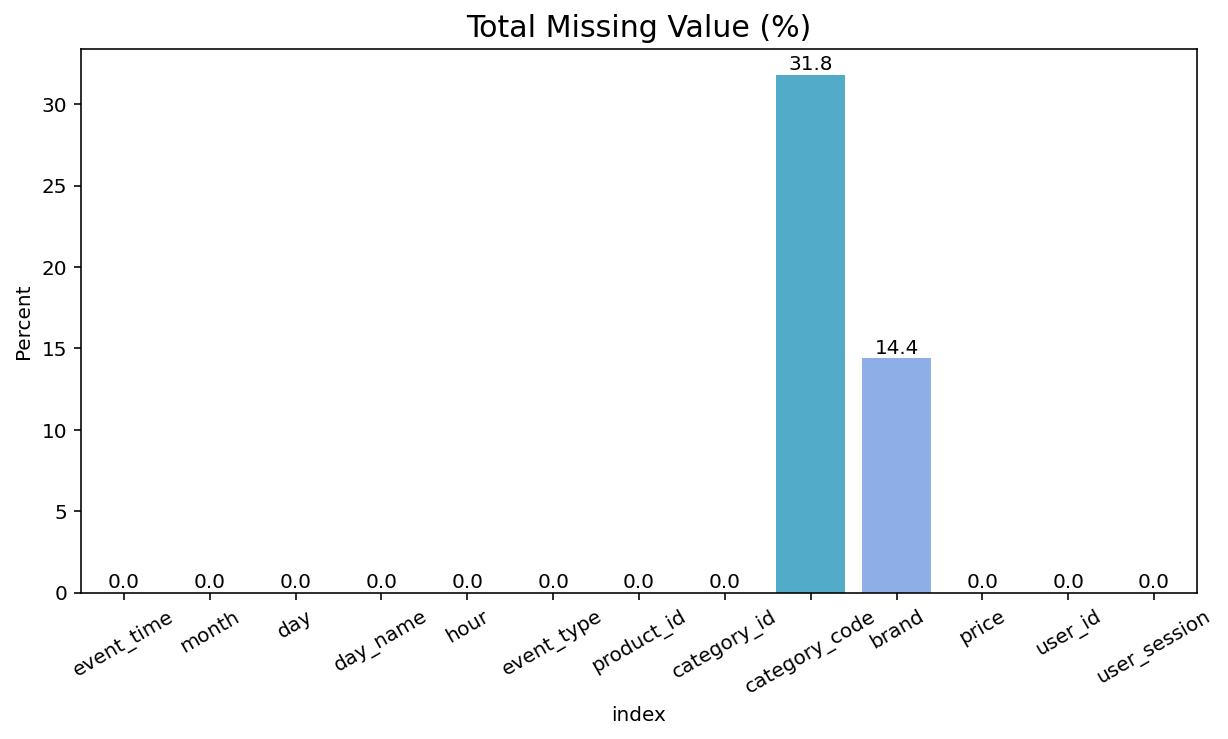

In [ ]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="Percent", data=missing_data.reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, "%.1f" % height, ha="center")

sns_pct.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

### 결측치 상관관계 확인

#### 걸측치 종류

- 완전 무작위 결측 (MCAR : Missing Completely At Random)

    - 변수 상에서 발생한 결측치가 다른 변수들과 아무런 상관이 없는 경우 완전 무작위 결측이라고 부른다.<br>
    대부분의 결측치 처리 패키지가 MCAR을 가정으로 하고 있고 보통 우리가 생각하는 결측치라고 생각하면 된다.   
    예를 들어, 데이터를 깜박하고 입력 안하거나 전산오류로 누락된 경우이다.   
    이러한 결측치는 보통 제거하거나 데이터 셋에서 단순 무작위 표본추출을 통해 완벽한 데이터셋으로 만들 수 있다.

- 무작위 결측 (MAR : Missing At Random)

    - 결측값이 결측된 변수와는 관련이 없지만 다른변수와는 관련이 있는 경우 무작위 결측이라고 부른다.  
    예를 들어, 여성이 남성보다 체중을 기입하지 않는다. 라고 하면 체중에 결측값이 생기지만,  
    이는 체중 변수와 관련이 있는 것이 아닌 성별 변수와 관련이 있다. 

- 비 무작위 결측 (MNAR : Missing Not At Random)

    - 위 두가지 유형이 아닌 경우 MNAR이라고 하고, 결측값이 결측된 변수와 관련이 있는 경우 비 무작위 결측이라고 한다.  
    예를 들어, 서비스에 불만족한 고객들은 만족도 설문에 응답하지 않는다.  
    
    - 링크 : https://syj9700.tistory.com/10

- 구분 예시

    * 비 무작위 결측 (MNAR)  

        + 우울증이 너무 심한 응답자들이 우울증 문항에 허위 기술을 하거나,  
        정치적, 종교적인 이유로 실제와 전혀 다른 응답하는 경우  
        
        + 위의 예시처럼 설문지 응답에서 중요한 특정 집단이 의도적으로 자신을 감춰버린 상태
    
    * 3번 상태 (NMAR)가 아니라면, 이 결측값 발생이 어느정도 독립적으로 발생하지 않았을까? 라고 생각 가능한 상태가 되고,
    이는 완벽하게 우연히 발생했다면 1번 완전 무작위 결측이 된다 (MCAR)

    * 즉, 결측값의 발생에 뚜렷한 어떤 인과 관계가 숨어있는지 여부로 구분지으면 된다  

    * 링크 : https://gooopy.tistory.com/43  

    * MCAR(Missing Completely At Random)
        
        + 특정 column(c_k)의 결측 여부가 완전히 random으로 발생하는 경우,  

        + 즉 c_k가 다른 c_1, c_2, ...와는 관련이 없을 때를 가리킴

    * MAR(Missing At Random)  

        + 특정 c_k의 결측 여부가 다른 c_1, c_2, ... 중 몇몇과 관련이 있는 경우  

        + 예를 들면, 소득수준(=c_1)에 따라 학업성취도(=c_k)의 결측 여부가 관련이 있을 경우

    * MNAR(Missing Not At Random, non ignorable)  

        + 특정 c_k의 결측 여부가 c_k의 값과 관련이 있는 경우  
        
        + 예를 들면, 학업성취도가 낮은 학생들이 학업성취도에 응답하지 않는 경우

#### 결측치 상관관계

Text(0.5, 1.0, 'Correlation with Missing Values')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


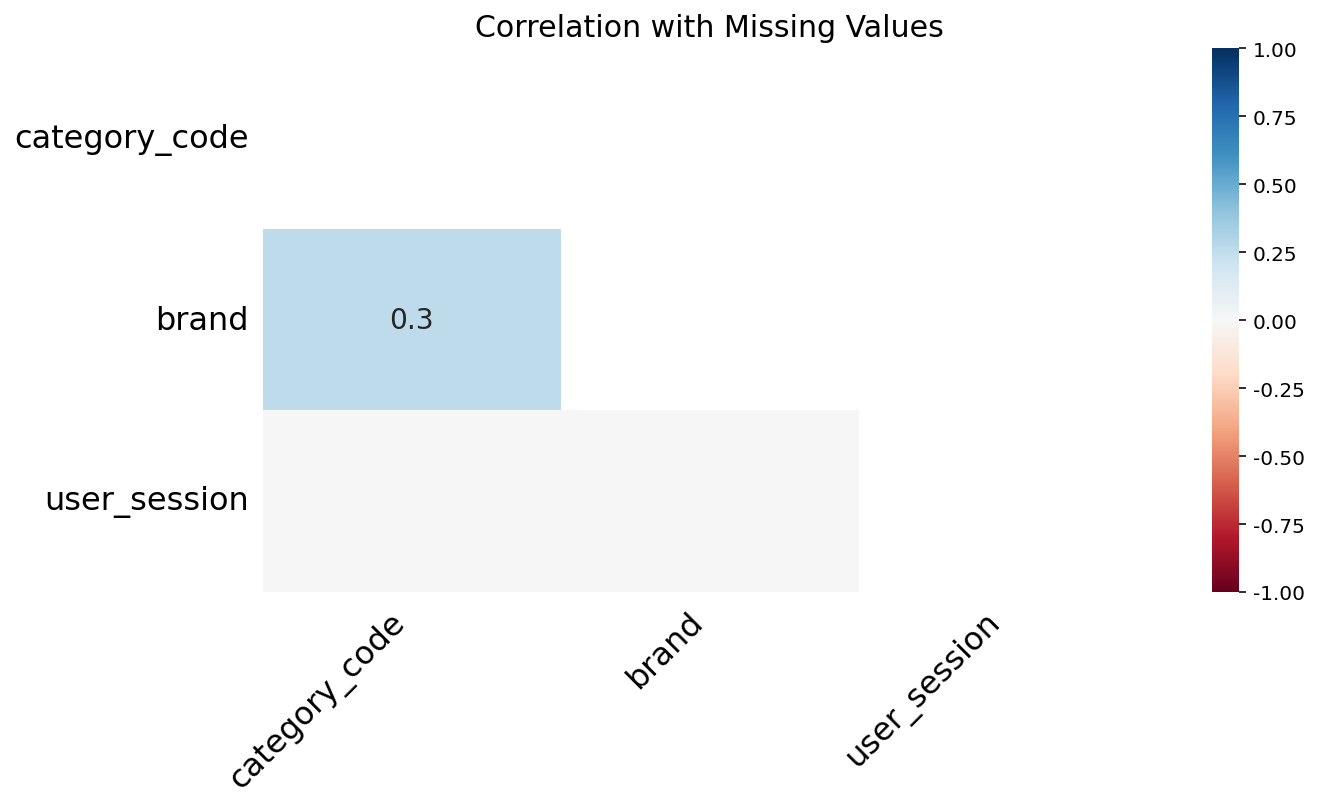

In [ ]:
missingdata_col = mod.columns[mod.isnull().any()].tolist()
msno.heatmap(mod[missingdata_col], figsize=(10, 5))
# msno.heatmap(mod, figsize=(10, 5))
plt.title("Correlation with Missing Values", fontsize=15)

# category_code, brand 상관관계 0.3
# category_code에 결측치가 있으면, brand에 결측치가 존재할 가능성이 어느정도 있다
# -> category_code, brand MCAR 결측치이다

### 결측치 제거

#### 만약 category_code, brand 동시에 결측된 값 제거한다면, 결측치 비율 어떨까?

In [ ]:
# 전체 값 대비 category_code, brand 전부 결측인 값들의 비율
null_cond = (mod["category_code"].isna()) & (mod["brand"].isna())
(mod[null_cond].shape[0] / mod.shape[0]) * 100

8.821333407964483

In [ ]:
# 전체 데이터에서 category_code, brand 둘다 NaN 값인 경우 제거
both_null_cond = (mod["category_code"].notna()) | (mod["brand"].notna())
mod[both_null_cond].shape

(38704217, 13)

In [ ]:
no_both_null = mod[both_null_cond]
no_both_null.shape

(38704217, 13)

In [ ]:
# 결측치 percent 구함
null_total_2 = no_both_null.isnull().sum()
null_count_2 = no_both_null.isnull().count()
percent_2 = round((null_total_2 / null_count_2) * 100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data_2 = pd.concat([null_total_2, percent_2], axis=1, keys=["Total", "Percent"])

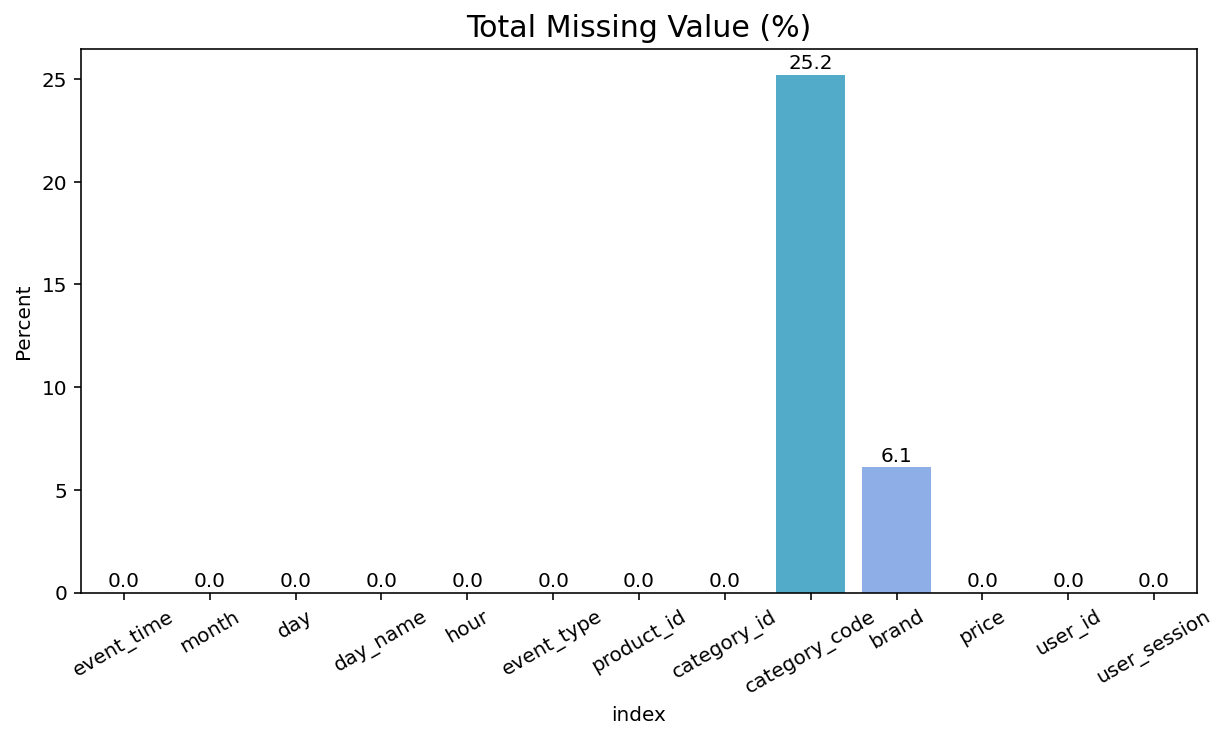

In [ ]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct_2 = sns.barplot(x="index", y="Percent", data=missing_data_2.reset_index())
sns_pct_2.set_xticklabels(sns_pct_2.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct_2.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, "%.1f" % height, ha="center")

sns_pct_2.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

#### 연속형 변수 상관관계

##### 상관관계 테이블 생성 (연속형 변수)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


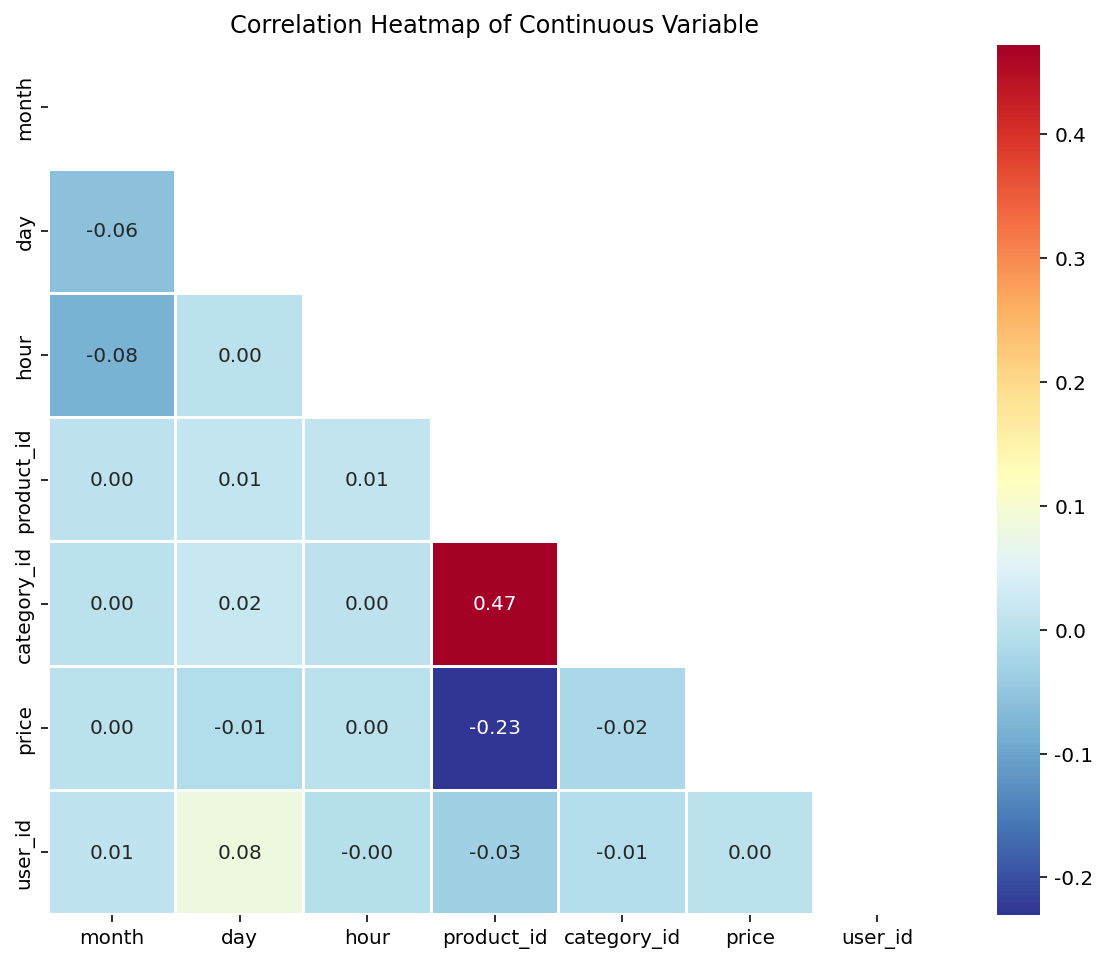

In [ ]:
# 상관계수 테이블
corr = no_both_null.corr()

# 히트맵 사이즈 설정
plt.figure(figsize=(10, 8))

# 히트맵 형태 정의. 여기서는 삼각형 형태 (위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
sns.heatmap(data=corr,          # corr = 상관계수 테이블
            annot=True,         # 히트맵에 값 표시
            mask=mask,          # 히트맵 형태, 여기서는 위에서 정의한 삼각형 형태
            fmt=".2f",          # 값 표시 방식. 소수점 2번째 자리까지
            linewidths=1.,      # 경계면 실선 구분 여부
            cmap="RdYlBu_r")    # 사용할 색 지정 (python colormap 검색)
plt.title("Correlation Heatmap of Continuous Variable")
plt.show()

# product_id, category_id 상관관계 0.47

### 결측치 탐색

In [ ]:
# category_id 컬럼의 결측치 데이터프레임으로 생성하여, kaspi.kz 홈페이지에 검색
def null_list(df, col, idx_num=15):
    
    na_cond = df["category_code"].isnull()                  # category_code가 NaN인 것 조건 설정
    null_cat = df[na_cond][f"{col}"].value_counts()         # 위의 조건 적용한 것 중, 컬럼 이름 col인 것 value_counts()
    null_cat_values = null_cat[idx_num:(idx_num+15)]        # value_counts()한 것들 15개 추려냄
    null_cat_list = null_cat_values.keys().tolist()         # 추려낸 15개 list 생성

    # 빈 데이터프레임 생성
    df_2 = pd.DataFrame()

    # null_cat_list에 있는 category_id로 for문 생성하여 product_id 탐색
    for cat_id in null_cat_list:
        cat_id_cond = (df["category_id"] == cat_id)
        # category_id로 검색한 것의 product_id 숫자 많은 것 중 중복안된 5개 prod_id list로 설정
        prod_id = df[cat_id_cond]["product_id"].value_counts().head(5).keys().tolist()
        value_count = df[cat_id_cond]["product_id"].value_counts().head(5).tolist()
        # 앞서 생성한 빈 데이터프레임에 category_id와 prod_id 채워넣음
        df_2 = df_2.append(pd.DataFrame(
            [[cat_id, prod_id, value_count]], columns=["category_id", "product_id", "value_count"])).reset_index(drop=True)
    return df_2

In [ ]:
# null_list 함수 mod 데이터프레임에 적용하여 해당 category_code 검색
# kaspi.kz 홈페이지에 해당 카테고리 검색하여, dict 파일로 생성
category_dict = {2053013553559896355 : 'auto.accessories.tire',
                 2053013563651392361 : 'accessories.jewelry',
                 2053013556168753601 : 'construction.tool.kit',
                 2053013563693335403 : 'accessories.jewelry',
                 2053013557024391671 : 'furniture.bedroom.set',
                 2053013563970159485 : 'appliances.kitchen.cooker',
                 2053013563173241677 : 'beauty.technique.dryer',
                 2053013553853497655 : 'beauty.perfumery',
                 2053013553375346967 : 'electronics.clock',
                 2053013563584283495 : 'accessories.jewelry',
                 2053013553526341921 : 'auto.accessories.disc',
                 2053013559733912211 : 'furniture.living_room',
                 2053013564918072245 : 'home.textiles.carpet',
                 2053013561218695907 : 'electronics.video.tv',
                 2053013552385491165 : 'appliances.environment.air_conditioning',
                 2062461754293617058 : 'auto.accessories.car_seat',
                 2053013552259662037 : 'appliances.environment.boiler',
                 2053013563550729061 : 'accessories.jewelry',
                 2053013558525952589 : 'electronics.smartphone.phone_accessories',
                 2053013558031024687 : 'furniture.kitchen.crockery',
                 2053013553484398879 : 'auto.accessories.battery',
                 2053013554994348409 : 'appliances.kitchen.multibaker',
                 2053013555355058573 : 'appliances.kitchen.multicooker',
                 2053013557166998015 : 'furniture.bedroom.mattress',
                 2085718636156158307 : 'furniture.bedroom.pillow',
                 2053013558190408249 : 'furniture.kitchen.pan',
                 2053013555287949705 : 'appliances.kitchen.meat_grinder',
                 2144356630513320518 : 'apparel.coat',
                 2053013560144954031 : 'appliances.kitchen.washer',
                 2053013554524586339 : 'electronics.audio.music_center'
                }

In [ ]:
df_mod = mod.copy()

In [ ]:
def fill_cat(df, col="category_code"):
    # category_code 열의 None값 nones에 선언
    nones = df[col].isnull()
    for cat_id, cat_code in category_dict.items():
        # category_id 열 값 중 cat_id와 동일한 값들을 찾는 조건 설정
        cat_cond = (df["category_id"] == cat_id)
        # category_code열의 none값들 중에 cat_cond 조건과 일치하는 것을 cat_code로 선언
        df.loc[nones & cat_cond, col] = cat_code

    return df

In [ ]:
fill_cat(df_mod).head(3)

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8


In [ ]:
print("fill_cat 함수 적용 후 category_code 결측치 개수 :", 
      mod["category_code"].isnull().sum(), "->", df_mod["category_code"].isnull().sum())
print("fill_cat 함수 적용 후 category_code 결측치 비율 :", round(4707919 / df_mod.shape[0] * 100), "%")

fill_cat 함수 적용 후 category_code 결측치 개수 : 13515609 -> 4707919
fill_cat 함수 적용 후 category_code 결측치 비율 : 11 %


In [ ]:
# df_mod에서 brand 열 결측치일 조건
br_null_cond = (df_mod["brand"].isnull())

In [ ]:
df_mod[br_null_cond]["category_code"].value_counts().head()

accessories.jewelry                 885890
furniture.bedroom.set               319443
furniture.living_room.cabinet       216334
electronics.clocks                  178826
appliances.kitchen.refrigerators    175636
Name: category_code, dtype: int64

In [ ]:
null_br_sum_5 = df_mod[br_null_cond]["category_code"].value_counts().head(5).sum()
# brand 결측치 6117080개
# brand가 None인 category_code Top 5개의 brand를 채웠을때, brand 결측치가 전체에서 차지하는 비율
print(round((6117080 - null_br_sum_5) / df_mod.shape[0] * 100), "%")

10 %


### 결측치 탐색하여 대체하고자 진행한 내용 주석화

In [ ]:
# brand가 None 값인 것들 중, 가장 많은 카테고리 코드인 accessories.jewelry 필터링
# 카테고리 코드가 accessories.jewelry인 것들의 브랜드 살펴본다
# cat_cond = (df_mod["category_code"] == "accessories.jewelry")
# df_mod.loc[cat_cond]["brand"].value_counts()

In [ ]:
# # brand가 None 이면서 category_code = accessories.jewelry인 것들 Top 20 확인
# df_mod.loc[br_null_cond & cat_cond]["product_id"].value_counts().head(20)

# 20개의 product_id 중, 4개를 제외하면 전부 lucente
# -> jewelry 카테고리 결측치 전부 lucente로 봐도 문제 없다

In [ ]:
# # brand가 None인 값들 중, 2번째로 많은 카테고리인 furniture.bedroom.set 살펴본다
# bed_set_cond = (df_mod["category_code"] == "furniture.bedroom.set")
# df_mod.loc[bed_set_cond]["brand"].value_counts()

In [ ]:
# # brand가 None 이면서 category_code = furniture.bedroom.set인 것들 Top 20 확인
# df_mod.loc[br_cond & bed_set_cond]["product_id"].value_counts().head(20)
# # horizon : 5
# # kovens : 1
# # astrid : 1
# # SlonimFurniture :  3
# # Stand furniture : 4
# # asian funiture : 3
# # Fant-furniture : 1
# # Mebelgrad : 1
# # olmeco : 1

# # 팔린 개수 가장 많은 것이 horizon이다
# # (1) 15100337, (2) 15100009, (3) 15100370, (5) 15100350, (8) 15100377
# # -> 최빈값인 horizon으로 교체

In [ ]:
# # brand가 None인 값들 중, 3번째로 많은 카테고리인 furniture.living_room.cabinet 살펴본다
# cab_cond = (df_mod["category_code"] == "furniture.living_room.cabinet")
# df_mod.loc[cab_cond]["brand"].value_counts()

In [ ]:
# # brand가 None 이면서 category_code = furniture.living_room.cabinet인 것들 Top 20 확인
# df_mod.loc[br_null_cond & cab_cond]["product_id"].value_counts().head(20)
# # 팔린 개수 가장 많은 것이 stand_furniture 이다
# # (1) 14701435, (13) 14700575, (14) 14701162, (19) 14701857

# # -> 최빈값인 stand_furniture로 교체

In [ ]:
# # brand가 None인 값들 중, 4번째로 많은 카테고리인 electronics.clocks 살펴본다
# clock_cond = (df_mod["category_code"] == "electronics.clocks")
# df_mod.loc[clock_cond]["brand"].value_counts()

In [ ]:
# # brand가 None 이면서 category_code = electronics.clocks인 것들 Top 20 확인
# df_mod.loc[br_null_cond & clock_cond]["product_id"].value_counts().head(20)
# # 팔린 개수 가장 많은 것이 q&q 이다
# # (1) 21404397, (2) 21402653, (8) 21402696, (9) 20404032 (14) 21404428
# # -> 최빈값인 q&q로 교체

In [ ]:
# # brand가 None인 값들 중, 5번째로 많은 카테고리인 appliances.kitchen.refrigerators 살펴본다
# fridge_cond = (df_mod["category_code"] == "appliances.kitchen.refrigerators")
# df_mod.loc[fridge_cond]["brand"].value_counts()

In [ ]:
# # brand가 None 이면서 category_code = appliances.kitchen.refrigerators인 것들 Top 20 확인
# df_mod.loc[br_null_cond & fridge_cond]["product_id"].value_counts().head(20)
# # 팔린 개수 top 20 전부 biryusa
# # -> 최빈값인 biryusa로 교체

### 주석화 해제

In [ ]:
# brand가 None인 값들 중, category code top 5, 최빈값 딕셔너리 생성
brand_dict = {"accessories.jewelry" : "lucente",
              "furniture.bedroom.set" : "horizon",
              "furniture.living_room.cabinet" : "stand_furniture",
              "electronics.clocks" : "q&q",
              "appliances.kitchen.refrigerators" : "biryusa"}

In [ ]:
def fill_br(df, col="brand"):
    # brand 열의 None값 nones에 선언
    nones = df[col].isnull()
    for cat_code, mode in brand_dict.items():
        # category_code 열 값 중 cat_code와 동일한 값들을 찾는 조건 설정
        cat_cond = (df["category_code"] == cat_code)
        # brand열의 none값들 중에 cat_cond 조건과 일치하는 것을 mode로 선언
        df.loc[nones & cat_cond, col] = mode

    return df

In [ ]:
df_mod2 = df_mod.copy()

In [ ]:
fill_br(df_mod2).head(3)

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8


In [ ]:
# brand 컬럼 None 값 6117080 -> 4340951

print("fill_br 함수 적용 후 brand 결측치 개수 :", 
      df_mod["brand"].isnull().sum(), "->", df_mod2["brand"].isnull().sum())
print("fill_br 함수 적용 후 brand 결측치 비율 :", 
      round(df_mod["brand"].isnull().sum() / df_mod.shape[0] * 100), "->", round(4707919 / df_mod2.shape[0] * 100), "%")

fill_br 함수 적용 후 brand 결측치 개수 : 6117080 -> 4340951
fill_br 함수 적용 후 brand 결측치 비율 : 14 -> 11 %


In [ ]:
df = df_mod2.copy()

In [ ]:
# category_code 결측, 브랜드 채워져 있는 조건
cat_null_br_ok = (df["category_code"].isnull()) & (df["brand"].notnull())

# category_code 채워지고, brand 결측일 조건
cat_ok_br_null = (df["category_code"].notnull()) & (df["brand"].isnull())

# category_code, brand 둘다 결측일 조건
both_null = (df["category_code"].isnull()) & (df["brand"].isnull())

In [ ]:
print("category_code 결측, 브랜드 채워져 있는것 :", df[cat_null_br_ok].shape[0], "개")
print("category_code 채워지고, brand 결측 :", df[cat_ok_br_null].shape[0],"개")
print("category_code, brand 둘다 결측 :", df[both_null].shape[0], "개")

category_code 결측, 브랜드 채워져 있는것 : 3186832 개
category_code 채워지고, brand 결측 : 2819864 개
category_code, brand 둘다 결측 : 1521087 개


In [ ]:
# 위에서 설정한 조건에 맞는 결측치들 채워줌
df.loc[cat_null_br_ok, "category_code"] = "no_cat"
df.loc[cat_ok_br_null, "brand"] = "no_brand"
df.loc[both_null, ["category_code", "brand"]] = "missing"

In [ ]:
# user_session 결측치 채워줌
cond_sess_id1 = (df["user_session"].isnull()) & (df["user_id"] == 557388939)
cond_sess_id2 = (df["user_session"].isnull()) & (df["user_id"] == 549825742)

df.loc[cond_sess_id1, "user_session"] = "9c11ac2d-5c56-4994-87e4-ea077ab0ab45"
df.loc[cond_sess_id2, "user_session"] = "aac8b299-4355-4c25-bbfe-c0369f19a3ce"

### 결측치 처리 완료한 데이터프레임 parquet 파일로 저장

In [ ]:
# 결측치 처리 완료 데이터프레임 parquet 파일로 저장
df.to_parquet("/content/drive/MyDrive/Colab Notebooks/Datasets/cp2_ecommerce/df_missing.parquet", engine="pyarrow", compression="gzip")

## 데이터셋 분석

In [5]:
parquet_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/cp2_ecommerce/df_mv_filled.parquet"
df = pd.read_parquet(parquet_path, engine='pyarrow')

### event_type 분포

In [ ]:
df["event_type"].value_counts(normalize=True)

view        0.960673
cart        0.021827
purchase    0.017500
Name: event_type, dtype: float64

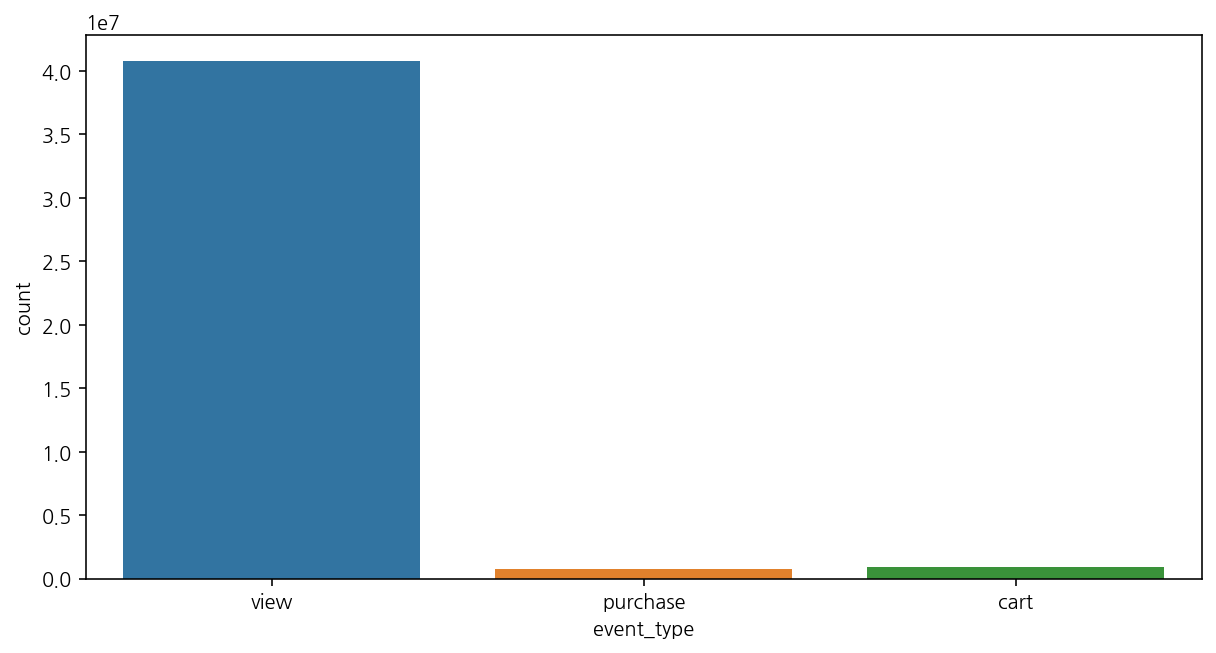

In [ ]:
# event_type 분포
plt.figure(figsize=(10, 5))
cnt = sns.countplot(x=df["event_type"])
plt.show()

### view, cart, purchase 분석

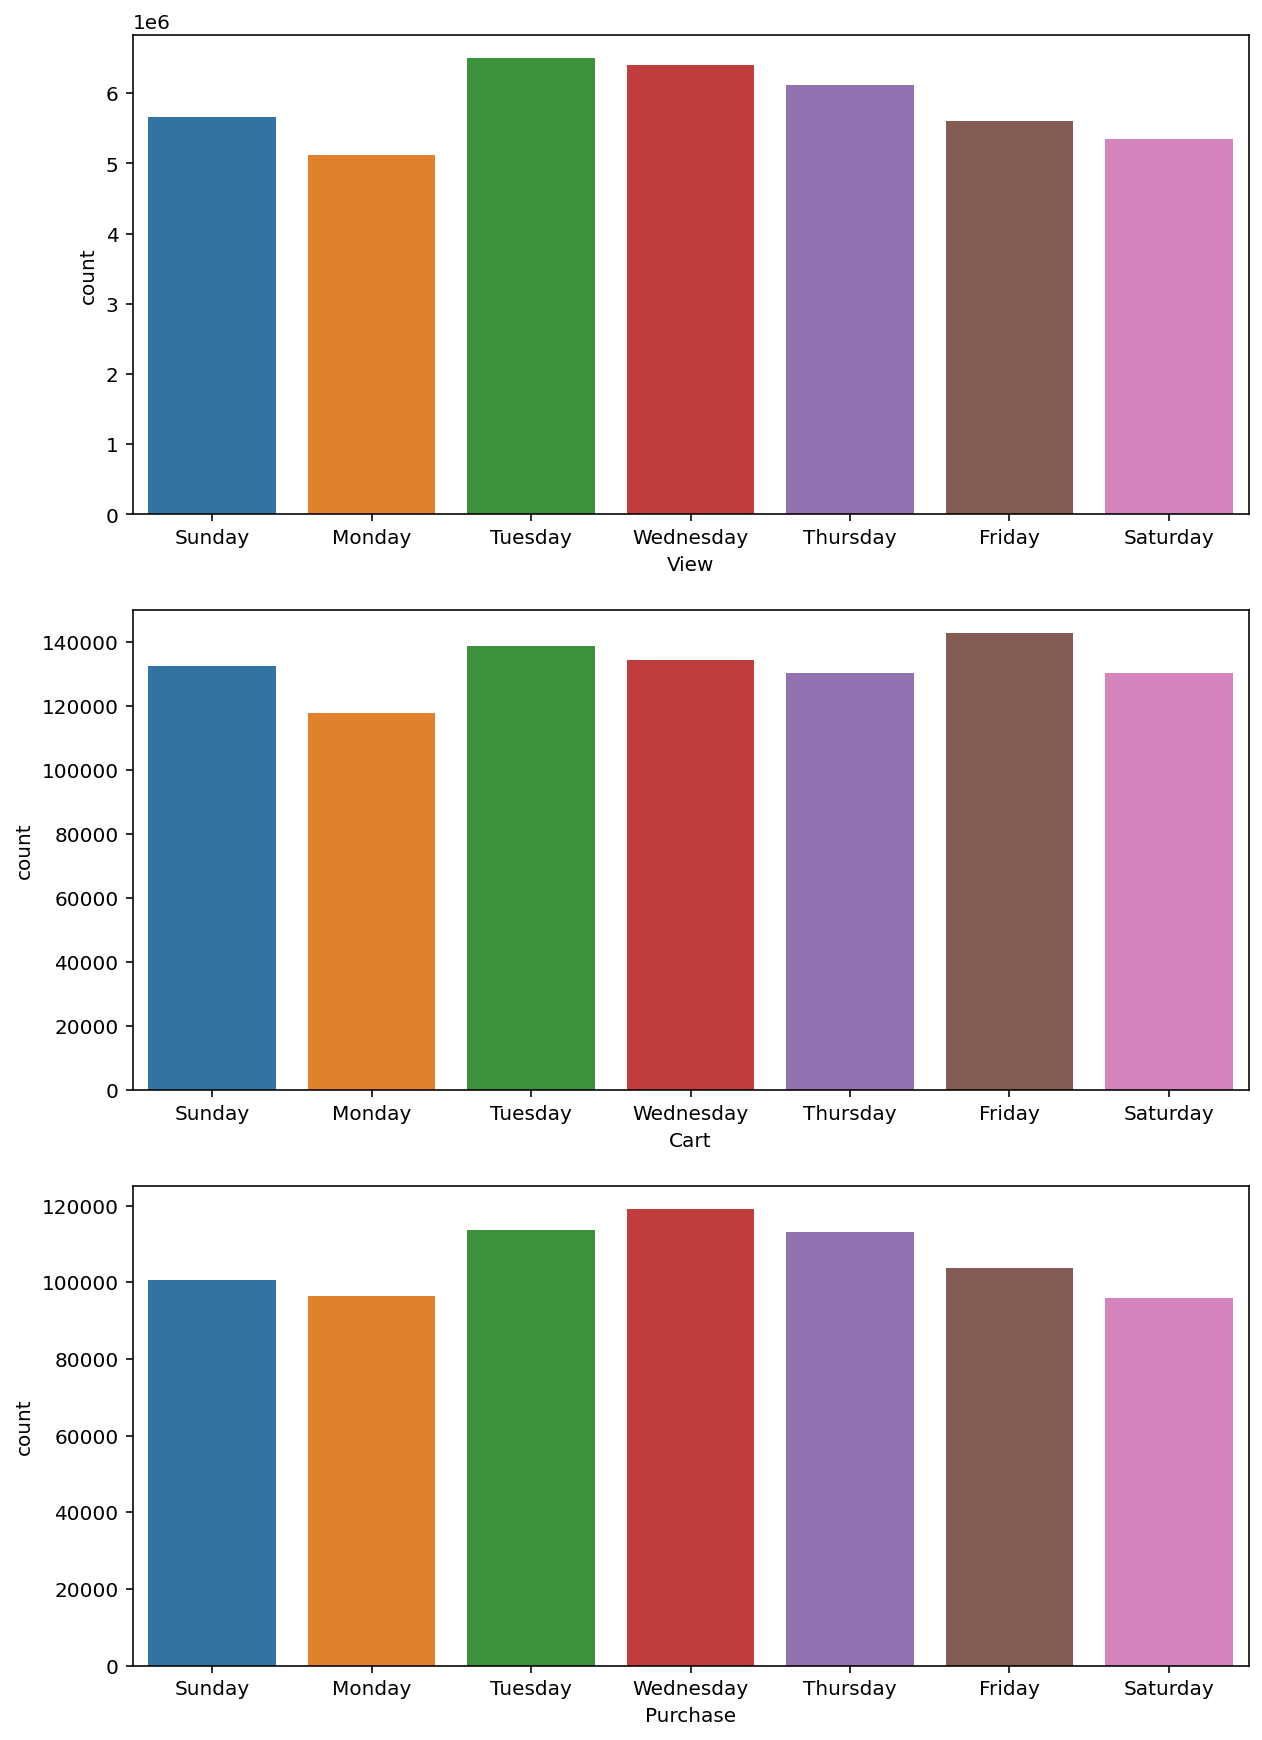

In [ ]:
# 상품 클릭, 장바구니, 구매 조건 설정
view_cond = (df["event_type"] == "view")
cart_cond = (df["event_type"] == "cart")
purchase_cond = (df["event_type"] == "purchase")

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_cnt = sns.countplot(x=df[view_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],              
                         ax=ax[0])
view_cnt.set_xlabel("View")

# 요일별 장바구니에 넣은 숫자
cart_cnt = sns.countplot(x=df[cart_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                         ax=ax[1])
cart_cnt.set_xlabel("Cart")

# 요일별 구매한 숫자
purchase_cnt = sns.countplot(x=df[purchase_cond]["day_name"],
                             order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                             ax=ax[2])
purchase_cnt.set_xlabel("Purchase")

plt.show()

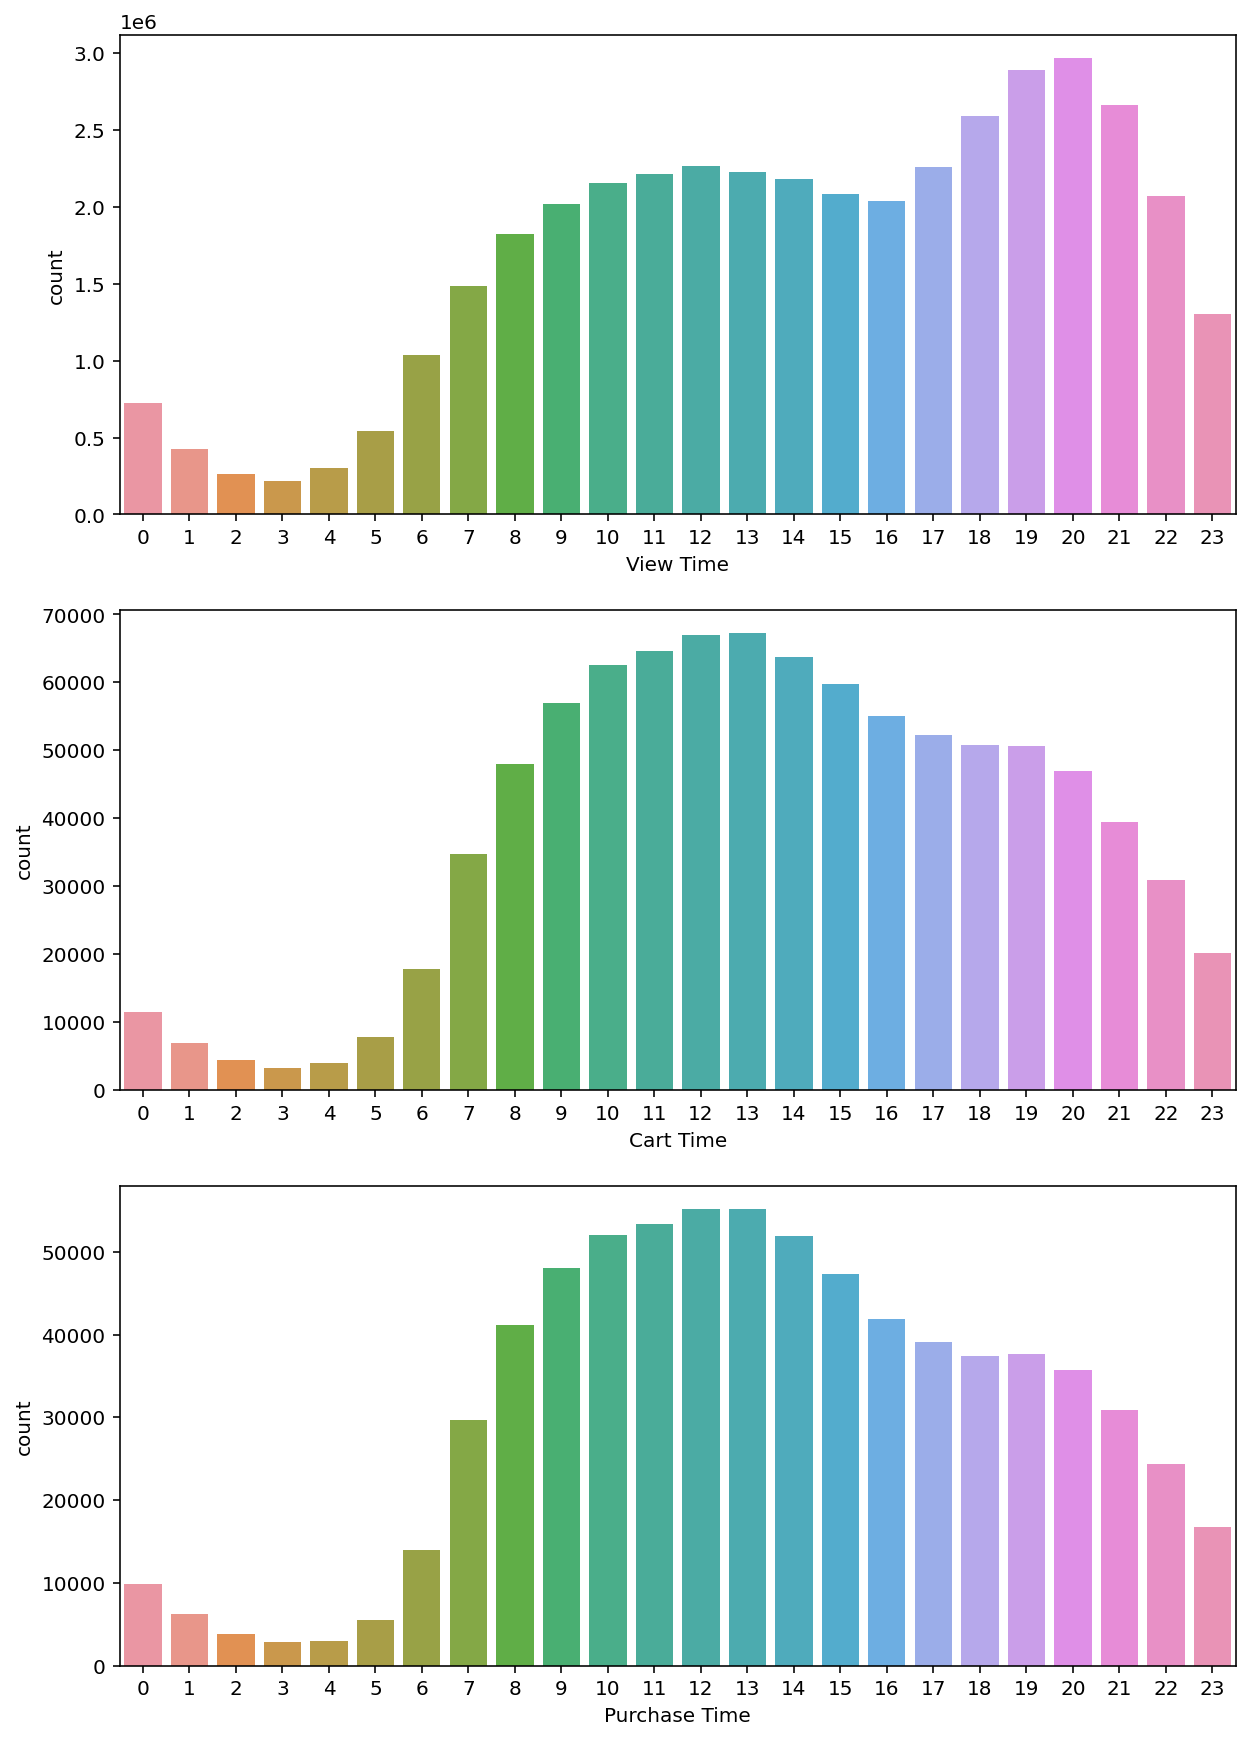

In [ ]:
# 시간대별 View, Cart, Purchase

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_time_cnt = sns.countplot(x=df[view_cond]["hour"],
                              ax=ax[0])
view_time_cnt.set_xlabel("View Time")

# 요일별 장바구니에 넣은 숫자
cart_time_cnt = sns.countplot(x=df[cart_cond]["hour"],
                         ax=ax[1])
cart_time_cnt.set_xlabel("Cart Time")

# 요일별 구매한 숫자
purchase_time_cnt = sns.countplot(x=df[purchase_cond]["hour"],
                             ax=ax[2])
purchase_time_cnt.set_xlabel("Purchase Time")

plt.show()

### 전체 category_code TOP 10 분석

In [ ]:
# 카테고리 코드 TOP 10
df["category_code"].value_counts()[:10]

electronics.smartphone         11507231
no_cat                          3186832
auto.accessories.tire           1888744
accessories.jewelry             1676223
missing                         1521087
electronics.clocks              1311033
electronics.video.tv            1285034
computers.notebook              1137623
electronics.audio.headphone     1100188
appliances.kitchen.washer        963381
Name: category_code, dtype: int64

In [ ]:
# 대분류 TOP 10
main_cat = df["category_code"].str.split(".").str[0].value_counts()[:10]
main_cat

electronics     16853504
appliances       6150611
auto             3422424
no_cat           3186832
furniture        2365596
computers        2324217
accessories      1914461
apparel          1643737
missing          1521087
construction     1425387
Name: category_code, dtype: int64

In [ ]:
# 중분류 TOP 10
sub_cat_1st = df["category_code"].str.split(".").str[1].value_counts()[:10]
sub_cat_1st

smartphone     11640652
kitchen         4648890
accessories     3422424
jewelry         1676223
audio           1666325
environment     1447916
clocks          1311033
video           1298188
shoes           1208383
notebook        1137623
Name: category_code, dtype: int64

In [ ]:
# 소분류 TOP 10
sub_cat_2nd = df["category_code"].str.split(".").str[2].value_counts()[:10]
sub_cat_2nd

tire             1888744
tv               1285034
headphone        1100188
washer            963381
refrigerators     887755
vacuum            801670
kit               694553
player            470208
set               466987
cooker            457909
Name: category_code, dtype: int64

In [ ]:
# 브랜드 TOP 10
brand_top10 = df["brand"].value_counts()[:10]
brand_top10

samsung     5282775
apple       4122554
xiaomi      3083763
no_brand    2819864
lucente     1541751
missing     1521087
huawei      1111205
lg           562404
bosch        557090
oppo         482887
Name: brand, dtype: int64

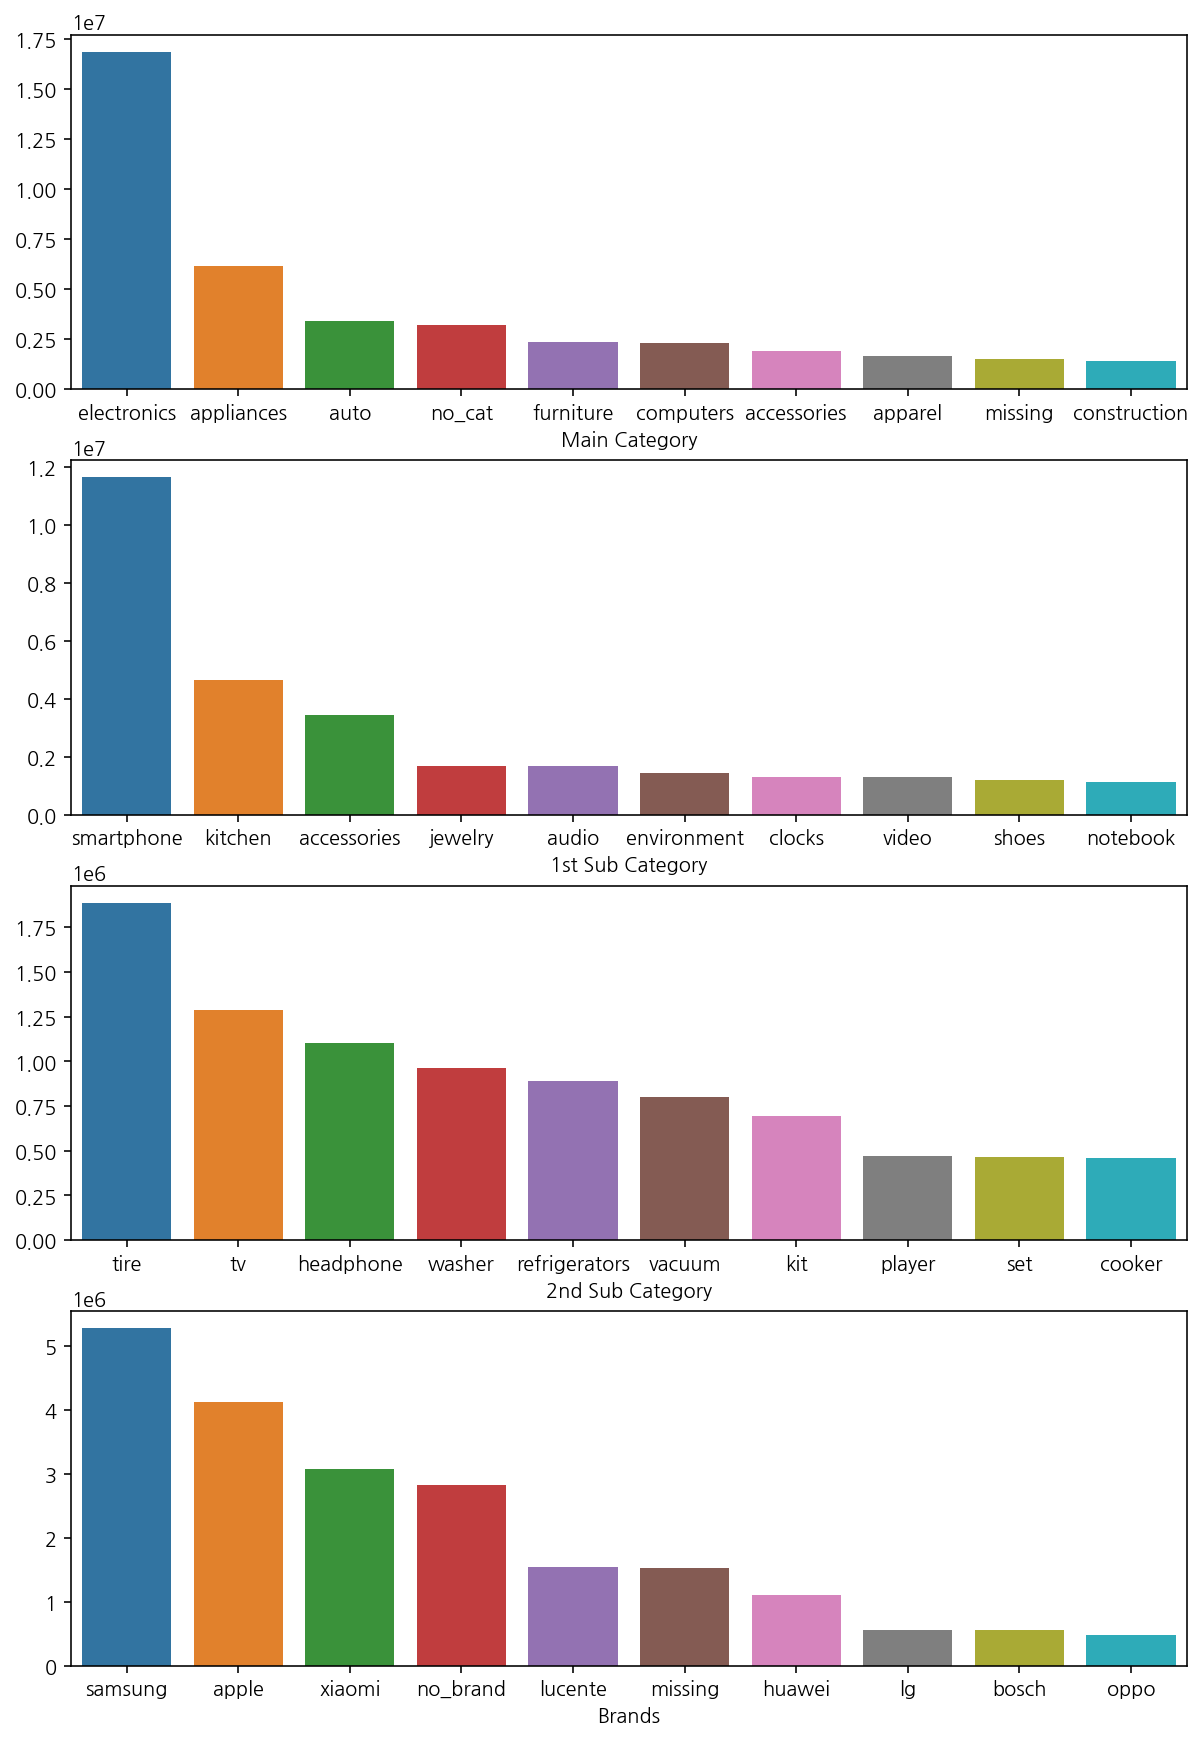

In [ ]:
# 카테고리별 TOP 10 (대분류, 중분류, 소분류), 브랜드 TOP 10

# 조건별로 plot 생성
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# 메인 카테고리 (대분류) Top 10
main_bar = sns.barplot(x=main_cat.index, 
                       y=main_cat.values,
                       ax=ax[0])
main_bar.set_xlabel("Main Category")

# 중분류 Top 10
sub_1st_bar = sns.barplot(x=sub_cat_1st.index,
                          y=sub_cat_1st.values,
                          ax=ax[1])
sub_1st_bar.set_xlabel("1st Sub Category")

# 소분류 Top 10
sub_2nd_bar = sns.barplot(x=sub_cat_2nd.index,
                          y=sub_cat_2nd.values,
                          ax=ax[2])
sub_2nd_bar.set_xlabel("2nd Sub Category")

# 브랜드 Top 10
brand_bar = sns.barplot(x=brand_top10.index,
                        y=brand_top10.values,
                        ax=ax[3])
brand_bar.set_xlabel("Brands")

plt.show()

#### category_code 별 view, cart, purchase 분석

In [ ]:
# event_type열 view, cart, purchase 조건 설정
view_cond = (df["event_type"] == "view")
cart_cond = (df["event_type"] == "cart")
purchase_cond = (df["event_type"] == "purchase")

# view, cart, purchase category_code TOP 10 검색
view_cat_count = df[view_cond]["category_code"].value_counts().head(10)
cart_cat_count = df[cart_cond]["category_code"].value_counts().head(10)
purchase_cat_count = df[purchase_cond]["category_code"].value_counts().head(10)

# view, cart, purchase category_code TOP 10 데이터프레임 생성
view_cat_df = pd.DataFrame(view_cat_count)
cart_cat_df = pd.DataFrame(cart_cat_count)
purchase_cat_df = pd.DataFrame(purchase_cat_count)

# view, cart, purchase top 10 데이터프레임 칼럼 변경
view_cat_df.reset_index(inplace=True)
view_cat_df.columns = ["view_category", "view_counts"]

cart_cat_df.reset_index(inplace=True)
cart_cat_df.columns = ["cart_category", "cart_counts"]

purchase_cat_df.reset_index(inplace=True)
purchase_cat_df.columns = ["purchase_category", "purchase_counts"]

# view, cart, purchase category_code TOP 10 데이터프레임 결합
pd.concat([pd.concat([view_cat_df, cart_cat_df], axis=1), purchase_cat_df], axis=1)

,view_category,view_counts,cart_category,cart_counts,purchase_category,purchase_counts
0,electronics.smartphone,10619448,electronics.smartphone,549765,electronics.smartphone,338018
1,no_cat,3135201,electronics.audio.headphone,51143,auto.accessories.tire,44019
2,auto.accessories.tire,1823852,electronics.video.tv,41667,electronics.audio.headphone,30503
3,accessories.jewelry,1651840,appliances.kitchen.washer,23137,no_cat,28830
4,missing,1501024,no_cat,22801,electronics.video.tv,25241
5,electronics.clocks,1272783,auto.accessories.tire,20873,accessories.jewelry,24383
6,electronics.video.tv,1218126,electronics.clocks,20344,electronics.clocks,17906
7,computers.notebook,1106406,electronics.clock,19951,appliances.kitchen.washer,16882
8,electronics.audio.headphone,1018542,appliances.environment.vacuum,17263,computers.notebook,15590
9,appliances.kitchen.washer,923362,computers.notebook,15627,missing,14349


#### brand 별 view, cart, purchase 분석

In [ ]:
# view, cart, purchase brand TOP 10 검색
view_br_count = df[view_cond]["brand"].value_counts().head(10)
cart_br_count = df[cart_cond]["brand"].value_counts().head(10)
purchase_br_count = df[purchase_cond]["brand"].value_counts().head(10)

# view, cart, purchase brand TOP 10 데이터프레임 생성
view_br_df = pd.DataFrame(view_br_count)
cart_br_df = pd.DataFrame(cart_br_count)
purchase_br_df = pd.DataFrame(purchase_br_count)

# view, cart, purchase top 10 데이터프레임 칼럼 변경
view_br_df.reset_index(inplace=True)
view_br_df.columns = ["view_brand", "view_counts"]

cart_br_df.reset_index(inplace=True)
cart_br_df.columns = ["cart_brand", "cart_counts"]

purchase_br_df.reset_index(inplace=True)
purchase_br_df.columns = ["purchase_brand", "purchase_counts"]

# view, cart, purchase brand TOP 10 데이터프레임 결합
pd.concat([pd.concat([view_br_df, cart_br_df], axis=1), purchase_br_df], axis=1)

,view_brand,view_counts,cart_brand,cart_counts,purchase_brand,purchase_counts
0,samsung,4806630,samsung,303249,samsung,172896
1,apple,3770597,apple,209084,apple,142873
2,xiaomi,2922650,xiaomi,104497,xiaomi,56616
3,no_brand,2782373,huawei,42132,no_brand,25491
4,lucente,1518812,oppo,20547,huawei,23501
5,missing,1501024,lg,13546,lucente,22939
6,huawei,1045572,no_brand,12000,missing,14349
7,bosch,544230,sony,10060,oppo,10891
8,lg,540131,acer,9400,cordiant,10551
9,oppo,451449,elenberg,8598,lg,8727


### 일일 매출, CVR 구하기

#### 일일 매출, CVR EDA

In [ ]:
#view_cond = (df["event_type"] == "view")
purchase_cond = (df["event_type"] == "purchase")

# view, purchase로 데이터프레임 분리
df_view = df.loc[view_cond]
df_purchase = df.loc[purchase_cond]

# event_time 출력 변경
df_view["event_time"] = df_view["event_time"].dt.to_period("D")
df_purchase["event_time"] = df_purchase["event_time"].dt.to_period("D")

visit_column = ["event_time", "user_session"]

# view, purchase 데이터프레임 event_time, user_session만 남김
df_view = df_view[visit_column]
df_purchase = df_purchase[visit_column]

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# event_time으로 groupby해서 일자별 유저 세션 숫자 구해본다
df_date_view = df_view.groupby("event_time").count().reset_index()
df_date_purchase = df_purchase.groupby("event_time").count().reset_index()

# view, purchase groupby한 것 merge
df_cvr = pd.merge(df_date_view, df_date_purchase, on="event_time")
df_cvr.rename(columns={"user_session_x":"view_session", 
                       "user_session_y":"purchase_session"}, 
              inplace=True)

# merge한 것에 cvr 컬럼 추가
df_cvr["CVR"] = round((df_cvr["purchase_session"] / df_cvr["view_session"]) * 100, 1)

# 일별 매출 구해본다
# event_time purchase인 것만 모아서 df_daily_purchase 생성
purchase_cond = (df["event_type"] == "purchase")
df_daily_purchase = df.loc[purchase_cond]
df_daily_purchase["event_time"] = df_daily_purchase["event_time"].dt.to_period("D")

# 매출 일자별로 groupby
df_daily_purchase = df_daily_purchase[["event_time", "price"]]
df_daily_purchase = df_daily_purchase.groupby("event_time").sum().reset_index()

# df_cvr 데이터프레임에 일일 매출 merge
df_cvr_price = pd.merge(df_cvr, df_daily_purchase, on="event_time")

df_cvr_price["day_name"] = df_cvr_price["event_time"].apply(lambda x: x.strftime("%a"))

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_cvr_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   event_time        32 non-null     period[D]
 1   view_session      32 non-null     int64    
 2   purchase_session  32 non-null     int64    
 3   CVR               32 non-null     float64  
 4   price             32 non-null     float64  
 5   day_name          32 non-null     object   
dtypes: float64(2), int64(2), object(1), period[D](1)
memory usage: 1.8+ KB


#### 일일 매출, CVR 시각화

Text(0.5, 1.0, 'Daily CVR')

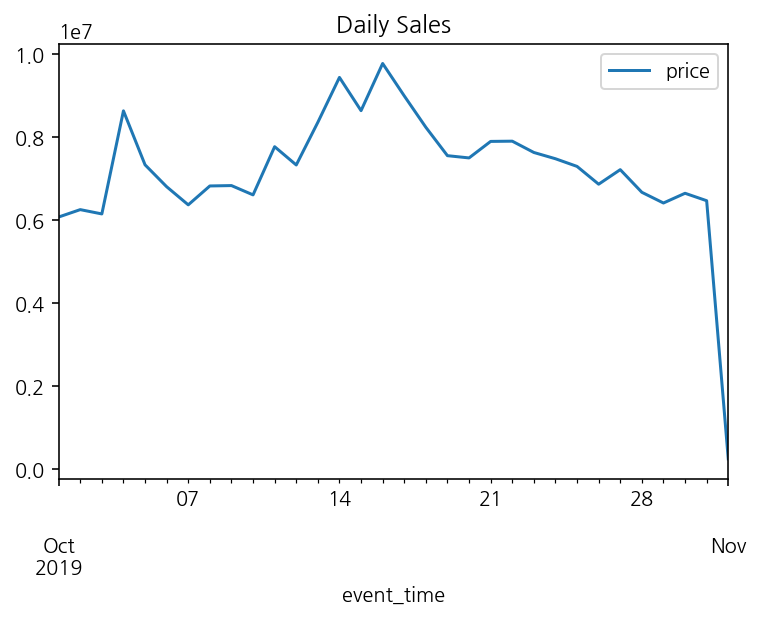

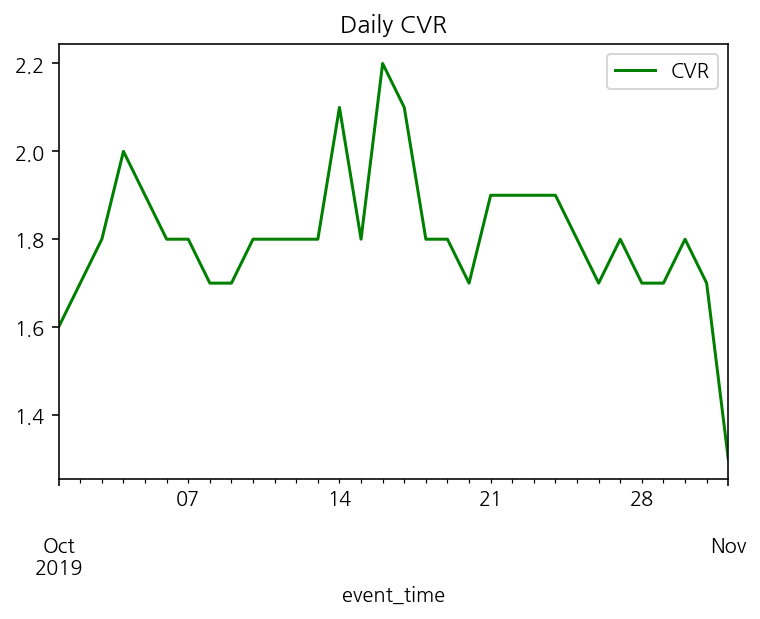

In [ ]:
# 일일 매출, CVR 시각화

sales_line = df_cvr_price.plot(x="event_time", y="price")
sales_line.set_title("Daily Sales")

cvr_line = df_cvr_price.plot(x="event_time", y="CVR", color="green")
cvr_line.set_title("Daily CVR")

### 요일, 시간별 Heatmap

In [ ]:
# 구매한 데이터들만 따로 df_pur에 선언
purchase_cond = (df["event_type"] == "purchase")
df_pur = df.loc[purchase_cond]

# event_time열 period 타입으로 변경
df_pur["event_time"] = df_pur["event_time"].dt.to_period("H")
# event_time으로 groupby한 후 전부 더해준다
df_pur = df_pur.groupby("event_time").sum().reset_index()

df_pur["day"] = df_pur["event_time"].dt.day
df_pur["hour"] = df_pur["event_time"].dt.hour

pur_columns = ["event_time", "day", "hour", "price"]
df_pur = df_pur[pur_columns].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_pur_pivot = df_pur.pivot_table(values="price", index="day", columns="hour")

In [ ]:
df_pur_pivot

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
1,82827.54,78043.44,43966.35,37108.56,2387.84,NaN,85533.96,252050.18,316664.79,404252.06,...,473258.18,376913.34,394692.53,354671.13,320170.93,288232.30,320258.59,247675.46,220146.94,151567.08
2,89416.87,63449.11,33872.48,21636.38,31016.98,58747.04,112034.67,227935.19,319197.26,423417.17,...,492673.17,371083.21,369725.07,321423.97,305396.37,302244.68,268879.00,280256.85,168028.30,158346.41
3,78566.96,46003.24,30547.19,21243.54,28466.29,34685.60,115456.19,270882.73,326559.86,390375.69,...,425025.68,384549.33,313432.01,318456.33,283278.73,308106.33,265771.51,255334.92,272355.68,184429.70
4,107046.56,79584.90,43736.26,37791.06,35890.34,82875.50,147835.09,317819.69,404246.32,475853.29,...,659097.70,649371.77,591273.81,610389.88,482975.30,394358.02,381647.34,348797.95,228435.41,194160.19
5,103889.63,74750.04,40967.97,47195.84,38604.39,77085.13,125147.75,284128.57,438129.95,469740.47,...,515545.27,479608.55,419566.69,372014.21,346541.97,269901.71,300283.55,288346.58,241573.31,167858.88
6,138045.46,64024.06,57291.33,23992.83,25534.81,38990.55,98471.97,202902.83,346660.47,429249.56,...,505010.04,465560.07,425426.01,334136.48,343230.06,323340.14,317124.16,277347.36,220076.85,155295.20
7,68022.78,72754.44,42674.79,40015.38,33385.27,53579.39,118561.88,233807.49,347667.53,411686.49,...,451751.89,410541.53,354722.19,331878.99,288921.08,318254.62,278121.55,267852.30,200867.95,139790.20
8,110217.97,48669.17,29866.61,21930.09,20414.09,46823.86,134287.62,287418.21,371982.31,425982.15,...,451662.37,432151.79,384337.04,360855.22,338438.39,302417.43,317210.70,280143.50,233808.83,181146.56
9,83086.43,64277.31,37980.79,29391.54,20403.14,49269.98,127867.22,280300.45,379111.29,444028.27,...,515014.92,398838.51,395459.63,366044.08,323978.31,352208.50,295614.28,253282.99,199882.32,154205.00


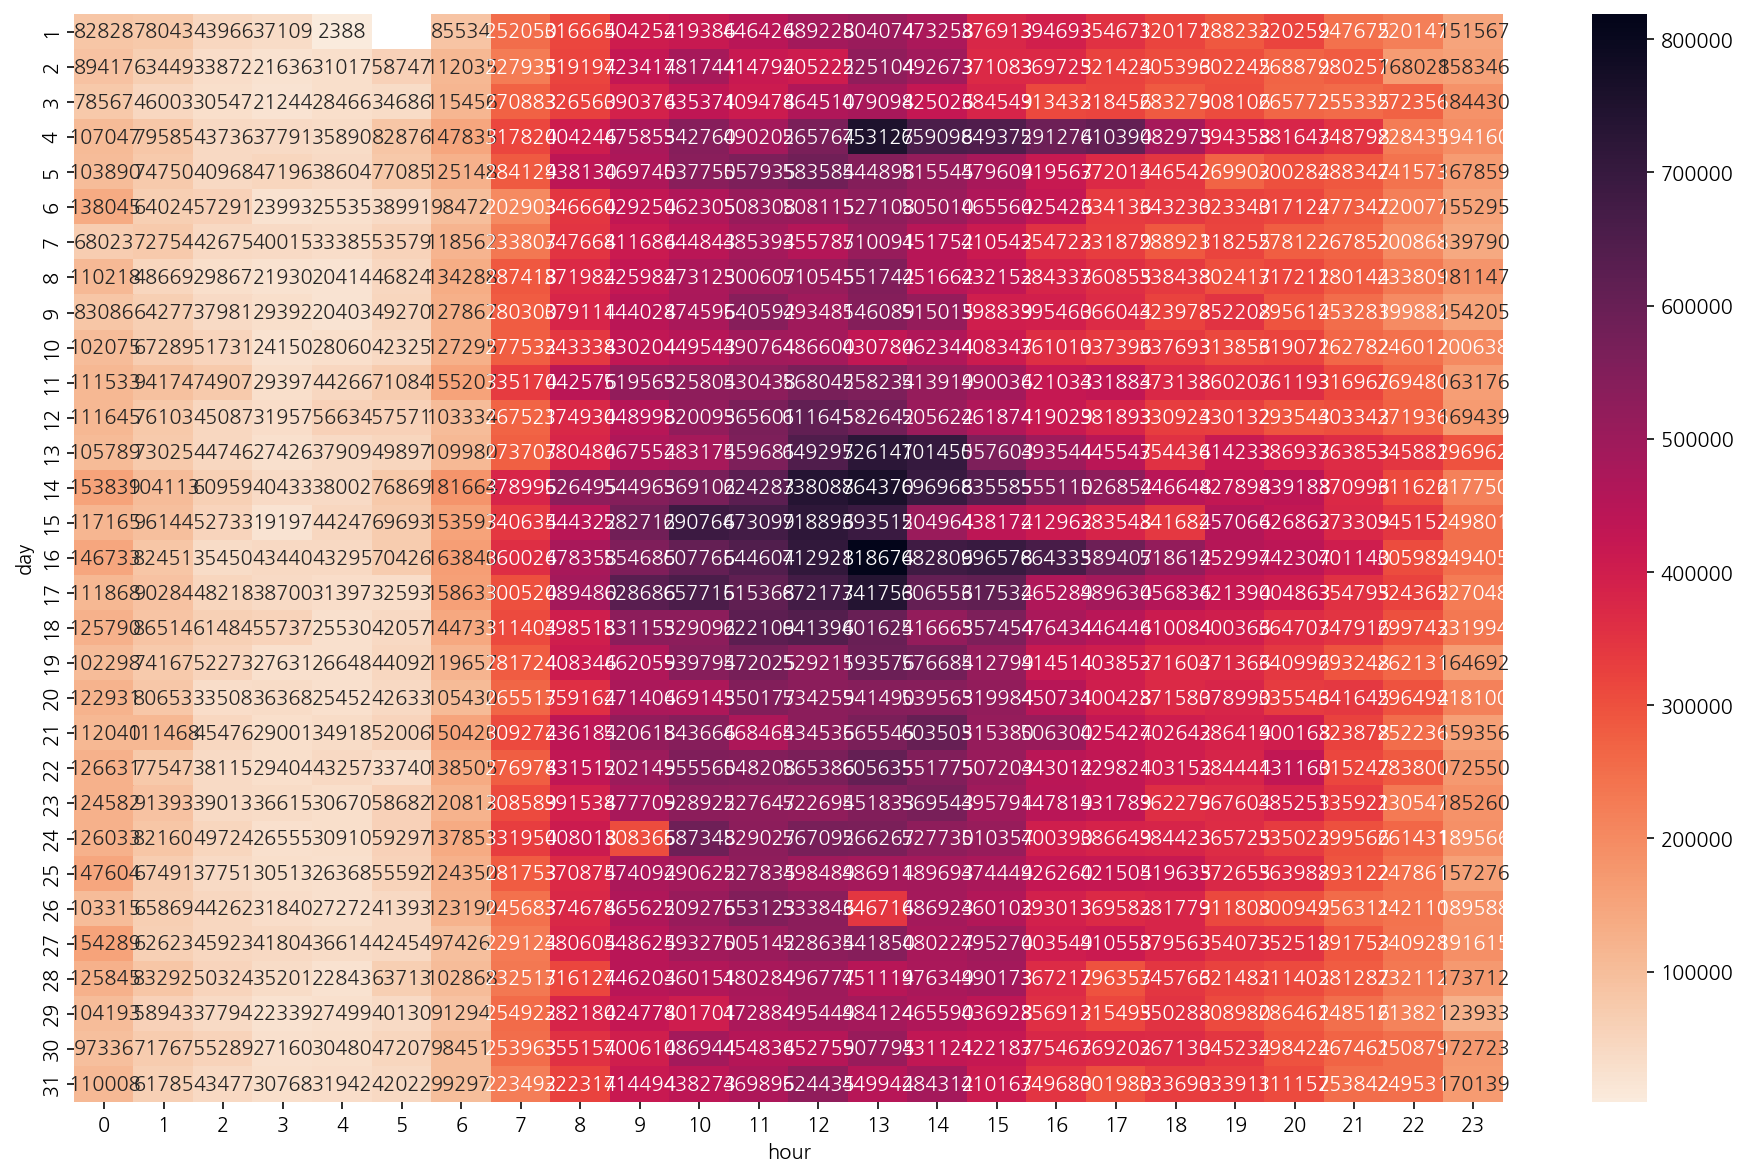

In [ ]:
# 일별 히트맵
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 크기 설정
plt.figure(figsize=(16,10))

# 히트맵 그래프 그리기
sns.heatmap(df_pur_pivot, annot = True, fmt='.0f',cmap='rocket_r')

# 그래프 표현
plt.show()

#### 요일별 구매 시간대 히트맵 구현해보기

In [ ]:
purchase_cond = (df["event_type"] == "purchase")
df_pur = df.loc[purchase_cond]

df_pur['event_time'] = df_pur['event_time'].dt.to_period('H')
df_pur = df_pur.groupby('event_time').sum().reset_index()
df_pur['weekday'] = df_pur['event_time'].apply(lambda x: x.strftime("%a"))
df_pur['hour'] = df_pur['event_time'].dt.hour
df_pur = df_pur[['event_time','weekday','hour','price']].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_day_pivot = df_pur.pivot_table(values='price', index='weekday', columns='hour')
df_day_pivot = df_day_pivot.round(0)
df_day_pivot = df_day_pivot.reindex(index=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

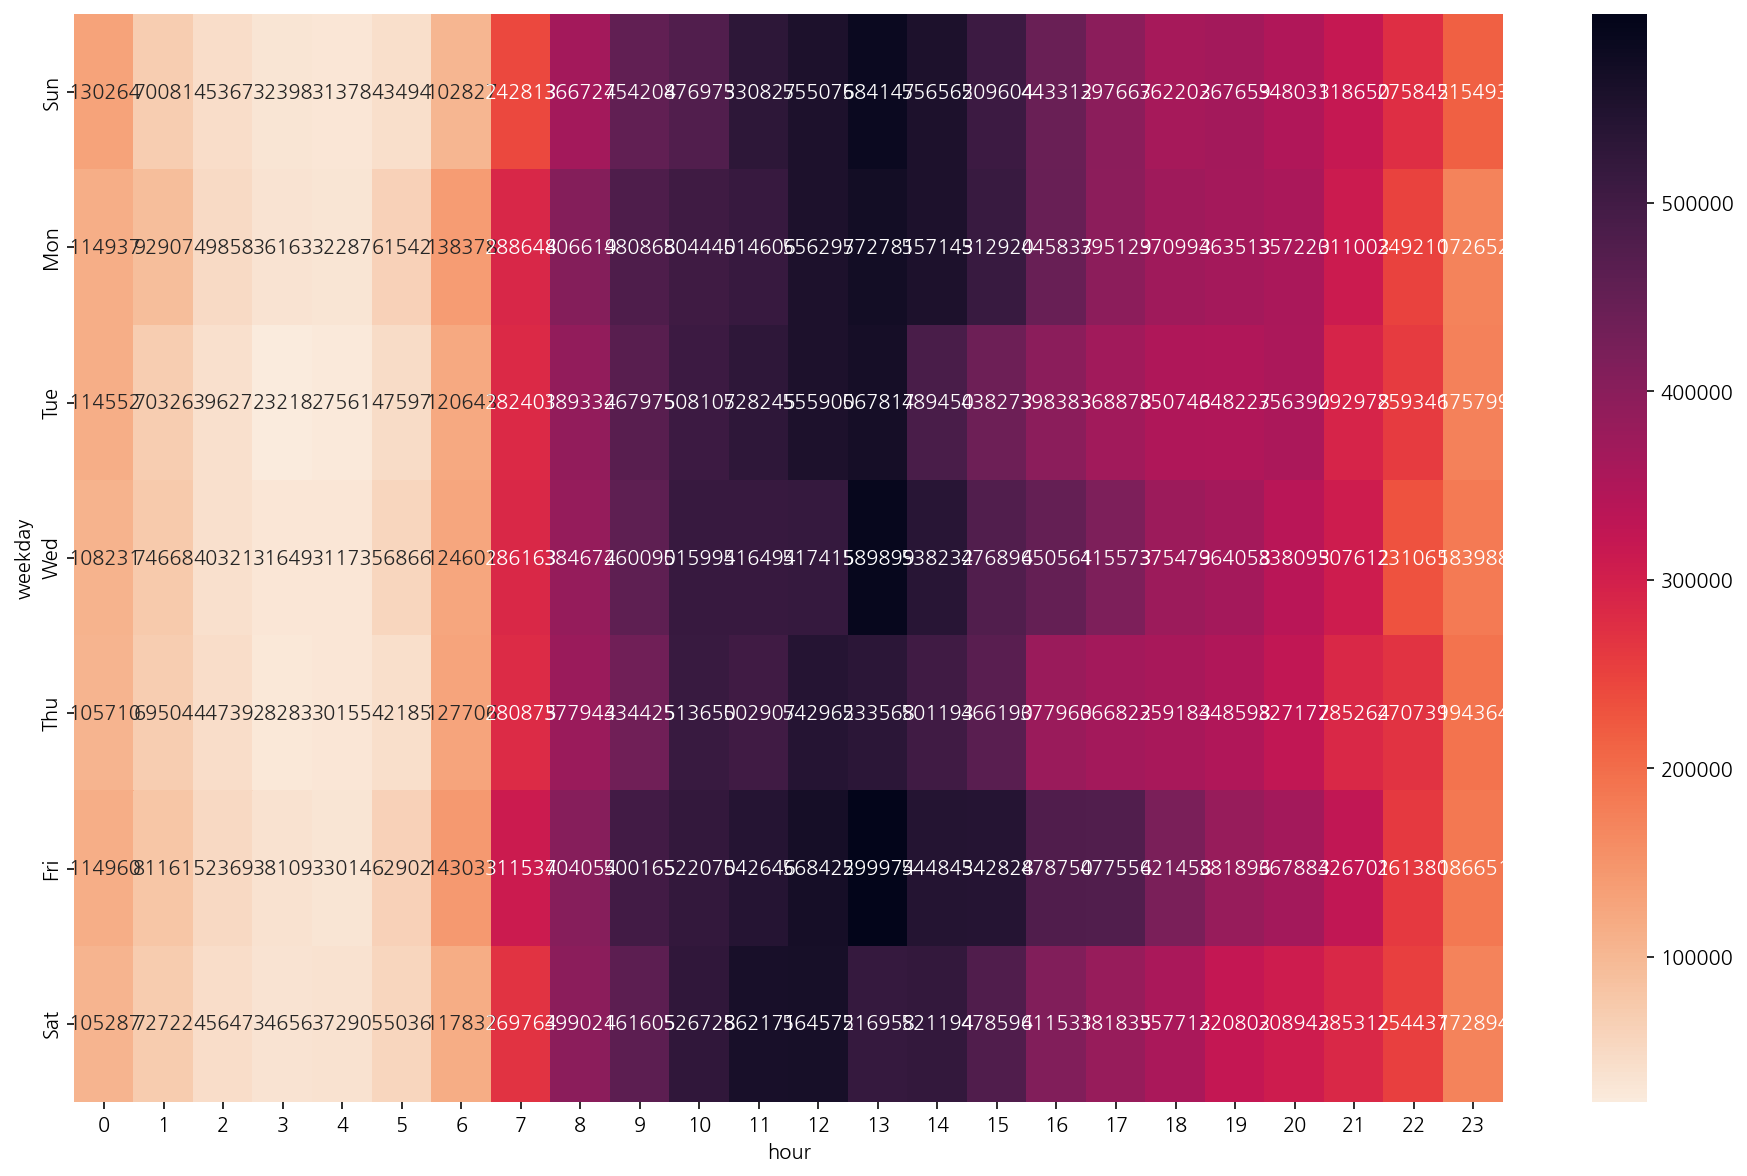

In [ ]:
# 히트맵 도전
import matplotlib.pyplot as plt
import seaborn as sns


# 그래프 크기 설정
plt.figure(figsize=(16,10))

# 히트맵 그래프 그리기
sns.heatmap(df_day_pivot, annot=True, fmt='.0f',cmap='rocket_r')

# 그래프 표현
plt.show()

### user_session 분석

#### id별 user_session 변화 시간 간격 체크 (가장 큰 간격)

In [7]:
from datetime import timedelta

def time_diff(df, user_id):
    user_cond = (df["user_id"] == user_id)
    user_df = df[user_cond]["event_time"]
    length = len(user_df)
    
    i = 1
    bigger = {}
    while i < length-1:
        
        pre_sec_diff = user_df.iloc[i] - user_df.iloc[i-1]
        post_sec_diff = user_df.iloc[i+1] - user_df.iloc[i]
        
        if post_sec_diff > pre_sec_diff:
            bigger[i] = post_sec_diff
            
        i += 1
    
    bigger_keys = list(bigger.keys())
    bigger_values = list(bigger.values())
    max_value = max(bigger.values())
    position = bigger_values.index(max_value)
    idx = bigger_keys[position]

    diff_dic = {"index_interval" : f"{idx} ~ {idx+1}",
                "time difference" : max_value,
                "user_id" : user_id,
                f"user_session (idx {idx})" : df[user_cond].iloc[idx]["user_session"],
                f"user_session (idx {idx+1})" : df[user_cond].iloc[idx+1]["user_session"]}

    return diff_dic

In [8]:
time_diff(df, 513605798)

{'index_interval': '1252 ~ 1253',
 'time difference': Timedelta('3 days 12:22:57'),
 'user_id': 513605798,
 'user_session (idx 1252)': 'd899b518-ff25-4920-a06d-c9032e2bb7ca',
 'user_session (idx 1253)': 'd899b518-ff25-4920-a06d-c9032e2bb7ca'}

In [9]:
time_diff(df, 542048657)

{'index_interval': '1523 ~ 1524',
 'time difference': Timedelta('6 days 23:07:50'),
 'user_id': 542048657,
 'user_session (idx 1523)': 'f3fde14e-c022-446a-9629-1a85f3102a8e',
 'user_session (idx 1524)': 'ccb2c18e-da99-4520-9dbe-5ad76ede3eb2'}

In [10]:
time_diff(df, 513851612)

{'index_interval': '9 ~ 10',
 'time difference': Timedelta('11 days 13:47:13'),
 'user_id': 513851612,
 'user_session (idx 10)': '89262cb0-471a-4374-b048-79ccdf958137',
 'user_session (idx 9)': 'edb4d48c-bfa8-4504-95f5-a69830171637'}

In [11]:
time_diff(df, 532769022)

{'index_interval': '75 ~ 76',
 'time difference': Timedelta('4 days 04:58:31'),
 'user_id': 532769022,
 'user_session (idx 75)': '4866e57c-50f4-4d87-b206-15f146c67b15',
 'user_session (idx 76)': 'a334026b-c2be-4a2a-9da2-a897cc2f4497'}

In [12]:
time_diff(df, 566165785)

{'index_interval': '77 ~ 78',
 'time difference': Timedelta('0 days 00:41:18'),
 'user_id': 566165785,
 'user_session (idx 77)': 'e9d2b8ad-3e69-47f2-8b8a-1fadfc583756',
 'user_session (idx 78)': 'e9d2b8ad-3e69-47f2-8b8a-1fadfc583756'}

#### id에 따라 user_session이 변할 때 시간 체크

In [18]:
from datetime import timedelta

def sess_diff(df, user_id):
    user_cond = (df["user_id"] == user_id)
    user_sess = df[user_cond]["user_session"]
    user_time = df[user_cond]["event_time"]
    user_event = df[user_cond]["event_type"]
    length = len(user_sess)

    diff_sess = {}
    date_time = []
    time_diff = []
    sess_idx = []
    sess_data = []
    event_data = []

    date_time.append(user_time.iloc[0])
    time_diff.append(timedelta(seconds=0))
    sess_idx.append(0)
    sess_data.append(user_sess.iloc[0])
    event_data.append(user_event.iloc[0])

    i = 1
    while i < length-1:

        if user_sess.iloc[i] != user_sess.iloc[i+1]:
            date_time.append(user_time.iloc[i+1])
            time_diff.append(user_time.iloc[i+1] - user_time.iloc[i])
            sess_idx.append(i+1)
            sess_data.append(user_sess.iloc[i+1])
            event_data.append(user_event.iloc[i+1])

        i+=1

    diff_sess["event_time"] = date_time
    diff_sess["event_type"] = event_data
    diff_sess["time_diff"] = time_diff
    diff_sess["sess_idx"] = sess_idx
    diff_sess["sess_data"] = sess_data
    
    sess_diff_df = pd.DataFrame(diff_sess)
    
    return sess_diff_df

In [19]:
sess_diff(df, 513605798)

,event_time,event_type,time_diff,sess_idx,sess_data
0,2019-10-01 07:23:28+04:00,view,0 days 00:00:00,0,fb075266-182d-4c11-b5f7-4e4dcdabd4a7
1,2019-10-07 17:24:58+04:00,view,0 days 00:36:54,1159,d899b518-ff25-4920-a06d-c9032e2bb7ca


In [20]:
sess_diff(df, 542048657)

,event_time,event_type,time_diff,sess_idx,sess_data
0,2019-10-22 07:06:12+04:00,view,0 days 00:00:00,0,0e5e2c6a-1349-41a0-ada3-b763523a50ab
1,2019-10-22 07:13:02+04:00,view,0 days 00:02:05,4,b766ffa1-a88e-4574-a4cb-bec08bd68414
2,2019-10-22 07:27:40+04:00,view,0 days 00:08:20,14,fe24d407-2b96-4d8f-b4ef-10e4567c8961
3,2019-10-22 08:36:22+04:00,view,0 days 00:35:41,43,cfb90a35-9575-495c-b6aa-48ddca2a7a9c
4,2019-10-22 14:45:02+04:00,view,0 days 00:02:25,1180,f3fde14e-c022-446a-9629-1a85f3102a8e
5,2019-10-29 15:11:54+04:00,view,6 days 23:07:50,1524,ccb2c18e-da99-4520-9dbe-5ad76ede3eb2
6,2019-10-29 15:12:43+04:00,view,0 days 00:00:49,1525,6fca5b5f-be98-4d3f-9e83-101251d23e67
7,2019-10-29 15:17:01+04:00,view,0 days 00:01:11,1541,09dc9390-ddbf-4b66-a417-32ea55c13642
8,2019-10-29 15:48:33+04:00,view,0 days 00:10:28,1619,218dd8bb-ccf1-4d51-bd57-4f8b782c8d70
9,2019-10-29 15:55:10+04:00,view,0 days 00:00:48,1655,43badaee-56d6-4018-9d4d-b20f57bfc0e4


In [21]:
sess_diff(df, 513851612)

,event_time,event_type,time_diff,sess_idx,sess_data
0,2019-10-02 12:48:45+04:00,view,0 days 00:00:00,0,93e8f122-ace0-4bc1-991b-bb8734d3ca0f
1,2019-10-12 21:41:06+04:00,view,10 days 08:51:43,2,edb4d48c-bfa8-4504-95f5-a69830171637
2,2019-10-24 11:32:21+04:00,view,11 days 13:47:13,10,89262cb0-471a-4374-b048-79ccdf958137
3,2019-10-24 12:11:44+04:00,view,0 days 00:31:15,15,09675282-69c7-4f8c-bda4-4053ab644b14
4,2019-10-24 12:27:05+04:00,view,0 days 00:03:47,29,2183f046-46f1-4ff6-96ef-f74986e7c8a1
5,2019-10-24 23:11:52+04:00,view,0 days 01:30:41,613,261f3793-c39d-4628-9e8f-3d532a2add27
6,2019-10-24 23:19:03+04:00,view,0 days 00:01:56,621,ccef2fc7-2fb4-41cf-9e01-74c42f4fdf83
7,2019-10-25 00:13:36+04:00,view,0 days 00:30:18,694,98742a85-b4a0-468a-9572-a8bd1ce7e453
8,2019-10-25 11:00:31+04:00,view,0 days 10:29:38,704,d0ae4449-43de-41d6-a5b0-24008c5ee9d3
9,2019-10-25 12:15:38+04:00,view,0 days 01:10:43,711,2f04a2b9-7ef9-4ca1-baea-98963c9c7376


In [26]:
sess_diff(df, 532769022)

,event_time,event_type,time_diff,sess_idx,sess_data
0,2019-10-01 18:56:45+04:00,view,0 days 00:00:00,0,f84940cb-0d07-4d2e-b582-5433b489ace6
1,2019-10-02 23:36:16+04:00,view,1 days 04:02:43,33,101c28de-4f2e-40da-9157-2aa8ec27b1a5
2,2019-10-05 20:25:09+04:00,view,2 days 20:41:26,43,6a3ec412-ada2-4eef-9602-79863e917e79
3,2019-10-07 05:21:35+04:00,view,1 days 08:49:10,59,a7bfba8d-7cf8-4e84-b35e-6f5769d67fb9
4,2019-10-10 21:38:14+04:00,view,3 days 16:13:51,64,057bd547-d568-4531-82f1-e44bfd3fe6fc
...,...,...,...,...,...
64,2019-10-30 12:04:17+04:00,view,0 days 00:01:30,2127,213caadb-cba9-470d-b0e3-7440f852f97a
65,2019-10-30 14:16:12+04:00,view,0 days 02:07:19,2135,fc2adfa7-9fc8-4d7b-bf46-bea942b8c594
66,2019-10-31 09:07:42+04:00,view,0 days 18:49:12,2143,069030fa-74f9-4d5e-ba39-42dc0b502e3c
67,2019-10-31 12:02:32+04:00,view,0 days 02:48:06,2163,95d77535-72a3-43cd-8ccd-d35bbc510a51


In [27]:
sess_diff(df, 566165785)

,event_time,event_type,time_diff,sess_idx,sess_data
0,2019-10-31 19:20:56+04:00,view,0 days,0,e9d2b8ad-3e69-47f2-8b8a-1fadfc583756


In [29]:
df.head(3)

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,no_cat,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,no_brand,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
